In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
import glob

print("Setup Done!")

Setup Done!


## Loding data from using ImageDataGenerator in TensorFlow

### ImageDataGenerator

```
Generate batches of tensor image data with real-time data augmentation.

Deprecated: tf.keras.preprocessing.image.ImageDataGenerator is not recommended for new code. 
Prefer loading images with tf.keras.utils.image_dataset_from_directory and transforming the output tf.data.Dataset with preprocessing layers.

```
- `rescale` : rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).
- `rotation_range` : Int. Degree range for random rotations.
- `width_shift_range` : Float, 1-D array-like or int
  - float: fraction of total width, if < 1, or pixels if >= 1.
  - 1-D array-like: random elements from the array.
  - int: integer number of pixels from interval (-width_shift_range, +width_shift_range) 
    - With width_shift_range=2 possible values are integers [-1, 0, +1], same as with width_shift_range=[-1, 0, +1], while with width_shift_range=1.0 possible values are floats in the interval [-1.0, +1.0).
  
- `height_shift_range` : Float, 1-D array-like or int
  - float: fraction of total height, if < 1, or pixels if >= 1.
  - 1-D array-like: random elements from the array.
  - int: integer number of pixels from interval (-height_shift_range, +height_shift_range) 
  - With height_shift_range=2 possible values are integers [-1, 0, +1], same as with height_shift_range=[-1, 0, +1], while with height_shift_range=1.0 possible values are floats in the interval [-1.0, +1.0).

- `shear_range` : Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
- `zoom_range` : Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
- `horizontal_filp` : Boolean. Randomly flip inputs horizontally.
- `fill_mode` : One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. Points outside the boundaries of the input are filled according to the given mode:
  - 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
  - 'nearest': aaaaaaaa|abcd|dddddddd
  - 'reflect': abcddcba|abcd|dcbaabcd
  - 'wrap': abcdabcd|abcd|abcdabcd

  
- `validation_split` : Float. Fraction of images reserved for validation (strictly between 0 and 1).
---

### flow_from_directory
```
Takes the path to a directory & generates batches of augmented data.
```
- `directory` : string, path to the target directory. It should contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator.
  
- `target_size` : Tuple of integers (height, width), defaults to (256,256). The dimensions to which all images found will be resized.
  
- `class_mode` : 	One of "categorical", "binary", "sparse", "input", or None. Default: "categorical". Determines the type of label arrays that are returned:
  - "categorical" will be 2D one-hot encoded labels,
  - "binary" will be 1D binary labels, "sparse" will be 1D integer labels,
  - "input" will be images identical to input images (mainly used to work with autoencoders).
  - If None, no labels are returned 
- `batch_size` : Size of the batches of data (default: 32).
- `subset` : Subset of data ("training" or "validation") if validation_split is set in ImageDataGenerator.

> reference : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [2]:
main_dir = "C:/git/lms_pj/project5/data/rps-cv-images"
train_data = ImageDataGenerator(rescale=1.0/255, 
                                rotation_range=20,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                validation_split=0.2
                                )

train_generator = train_data.flow_from_directory(main_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(60, 40),
                                                    subset='training')

validation_data = ImageDataGenerator(rescale=1.0/255,
                                        validation_split=0.2)

validation_generator = validation_data.flow_from_directory(main_dir,
                                                            batch_size=32,
                                                            class_mode='categorical',
                                                            target_size=(60, 40),
                                                            subset='validation')
print("Done!")

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.
Done!


## Building model keras API

```
ReduceLROnPlateau : Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

```

- `monitor` : quantity to be monitored.

- `factor` : factor by which the learning rate will be reduced. new_lr = lr * factor.

- `patience` : number of epochs with no improvement after which learning rate will be reduced.

- `verbose` : int. 0: quiet, 1: update messages.

- `min_lr` : lower bound on the learning rate.

> reference : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', input_shape=(60, 40, 3)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='Same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='Same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 36, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 56, 36, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 36, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 18, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 18, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 9, 128)       0

In [4]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2, 
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000003)

In [5]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(train_generator, 
                    epochs=25,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[learning_rate_reduction])

Epoch 1/25
55/55 [==============================] - 10s 177ms/step - loss: 1.3967 - acc: 0.4637 - val_loss: 1.0617 - val_acc: 0.3593 - lr: 0.0010
Epoch 2/25
55/55 [==============================] - 10s 174ms/step - loss: 0.6473 - acc: 0.7122 - val_loss: 0.8933 - val_acc: 0.7757 - lr: 0.0010
Epoch 3/25
55/55 [==============================] - 10s 177ms/step - loss: 0.5205 - acc: 0.7887 - val_loss: 0.7527 - val_acc: 0.8124 - lr: 0.0010
Epoch 4/25
55/55 [==============================] - 10s 177ms/step - loss: 0.4925 - acc: 0.8132 - val_loss: 0.6287 - val_acc: 0.7895 - lr: 0.0010
Epoch 5/25
55/55 [==============================] - ETA: 0s - loss: 0.2776 - acc: 0.9035
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
55/55 [==============================] - 10s 175ms/step - loss: 0.2776 - acc: 0.9035 - val_loss: 0.5143 - val_acc: 0.7483 - lr: 0.0010
Epoch 6/25
55/55 [==============================] - 10s 178ms/step - loss: 0.1701 - acc: 0.9377 - val_loss: 0.3148 -

## Ploting traing and validation accuracy

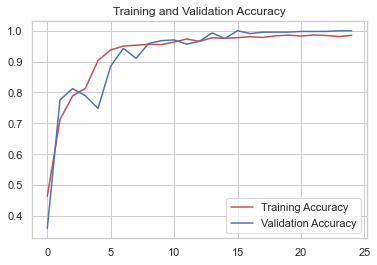

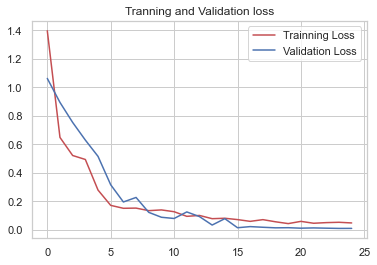

In [6]:
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Trainning Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss') 
plt.title('Tranning and Validation loss')
plt.legend()

plt.show()

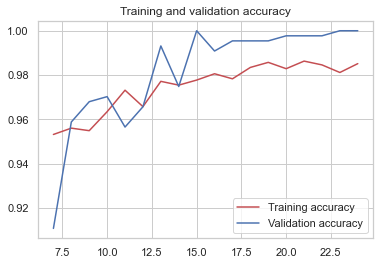

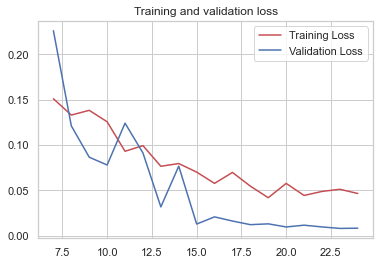

In [7]:
%matplotlib inline
acc = history.history['acc'][7:]
val_acc = history.history['val_acc'][7:]
loss = history.history['loss'][7:]
val_loss = history.history['val_loss'][7:]

epochs = range(7, 7+len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()